In [1]:
!pip install imutils tensorflow==2.3

In [2]:
!pip install GoogleDriveDownloader

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1lmMm-G2SspOnQ5xjV9gRPxLzTsriI_Zx',
                                    dest_path='./face_mask.zip',
                                    unzip=True)

In [19]:
import tensorflow as tf

In [4]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [5]:
preds = ['with_mask', 'without_mask']

In [37]:


data = []
labels = []

for pred in preds:
    path = os.path.join("./dataset", pred)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(pred)


[INFO] loading images...


In [7]:
shuffled_data = data
np.random.shuffle(shuffled_data)

WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the val

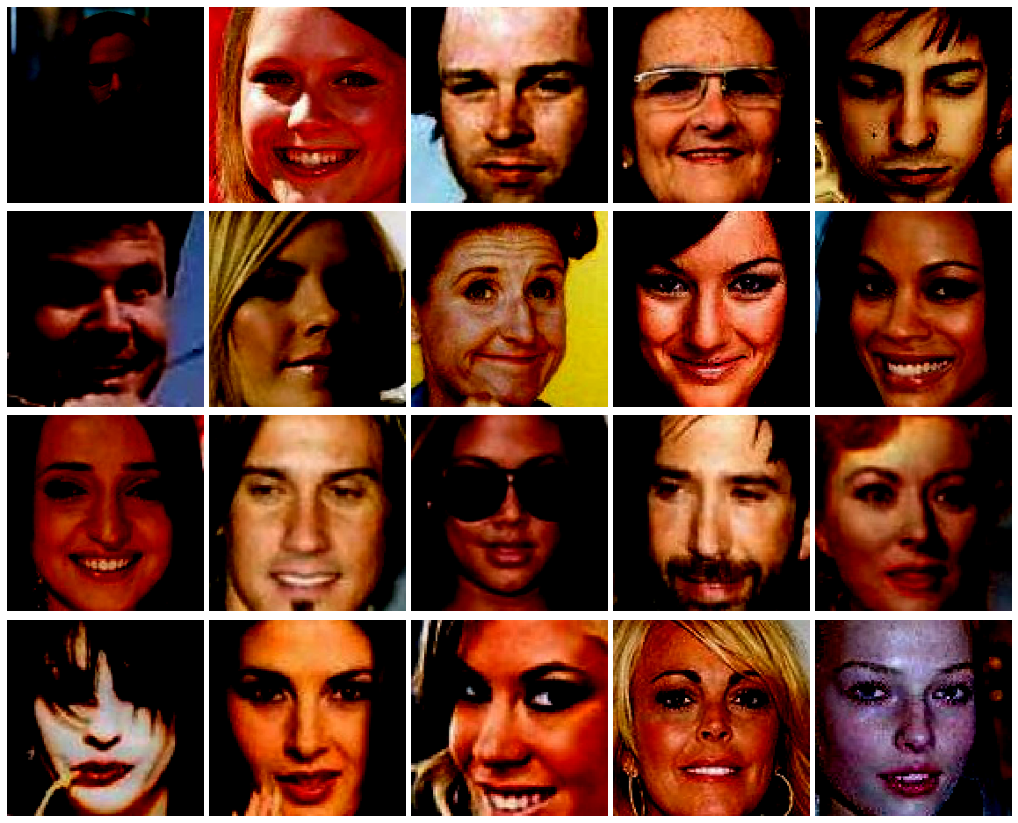

In [38]:
# code to view the images
num_rows, num_cols = 4, 5
f, ax = plt.subplots(num_rows, num_cols, figsize=(18,15),
                     gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                     squeeze=True)

for r in range(num_rows):
    for c in range(num_cols):
      
        image_index = r * 5 + c
        ax[r,c].axis("off")
        ax[r,c].imshow( shuffled_data[image_index], cmap='gray')
        # ax[r,c].set_title('No. %d' % data[image_index][1])
plt.show()
plt.close()

In [39]:

# hot encoding the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)



In [ ]:
# data augmentation to increase the size of the dataset
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [40]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


WARNING - `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


In [41]:

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [42]:
model = Model(inputs=baseModel.input, outputs=headModel)


In [ ]:

# setting the trainable of the layers to false; not to update the weights of the neurons
for layer in baseModel.layers:
	layer.trainable = False


In [43]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# compiling our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [28]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [44]:
# train the head of the network

#setting callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                               restore_best_weights=True,
                                               verbose=1)

H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	es_callback,
	epochs=EPOCHS)




[INFO] training head...
Epoch 1/20
281/281 [==============================] - 115s 409ms/step - loss: 0.2024 - accuracy: 0.9202 - val_loss: 0.0574 - val_accuracy: 0.9827
Epoch 2/20
281/281 [==============================] - 100s 356ms/step - loss: 0.0785 - accuracy: 0.9741
Epoch 3/20
281/281 [==============================] - 99s 353ms/step - loss: 0.0614 - accuracy: 0.9781
Epoch 4/20
281/281 [==============================] - 99s 353ms/step - loss: 0.0556 - accuracy: 0.9820
Epoch 5/20
281/281 [==============================] - 101s 358ms/step - loss: 0.0504 - accuracy: 0.9847
Epoch 6/20
281/281 [==============================] - 99

WARNING - Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 70 batches). You may need to use the repeat() function when building your dataset.


In [ ]:
# saving the model

model_name = 'face_mask.model'
model.save(model_name)